In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

import random

In [16]:
WIDTH=150
HEIGHT=150
IMAGE_SIZE=(WIDTH, HEIGHT)
IMAGE_CHANNELS=3
batch_size = 20

In [3]:
pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 13.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import py7zr

# with ZipFile('../content/drive/MyDrive/GlassMetal.zip', 'r') as zip:
#     zip.extractall()


with py7zr.SevenZipFile('../content/drive/MyDrive/UnSortedWaste.7z', mode='r') as z:
     z.extractall()


In [6]:
path =  "../content/UnSortedWaste"
train_dir = os.path.join(path, "train")
validation_dir = os.path.join(path, "validation")
filenames = os.listdir(path)

In [ ]:
#delete dirs
# shutil.rmtree( train_dir )
# shutil.rmtree( validation_dir )



In [7]:
labels = ["cardboard", "glass", "metal", "plastic", "trash", "paper"]
labels.sort()

os.makedirs(train_dir)
os.makedirs(validation_dir)

for label in labels:
  os.makedirs(os.path.join(train_dir, label))
  os.makedirs(os.path.join(validation_dir, label))


In [8]:
df = pd.DataFrame(data=filenames, columns=['file_name'])
total_train, total_validate = 0, 0

df['label'] = df['file_name'].apply(lambda x: "cardboard" if x[:3]=='car'
                                    else 'glass' if x[:3]=='gla'
                                    else "metal" if x[:3]=='met'
                                    else "paper" if x[:3]=='pap'
                                    else "plastic" if x[:3]=="pla"
                                    else "trash")


for label in df['label'].unique():
    files = df[df['label']==label]['file_name']
    train = np.random.choice(files, size=int(len(files)*0.8))
    test = [_ for _ in files if not (_ in train)]
    print(label, len(files), len(train), len(test))
    total_train += len(train)
    total_validate += len(test)

    for file in train:
      shutil.copyfile(os.path.join(path, file),
                     os.path.join(train_dir, label, file))

    for file in test:
      shutil.copyfile(os.path.join(path, file),
                     os.path.join(validation_dir, label, file))


glass 501 400 223
metal 410 328 189
plastic 482 385 205
cardboard 403 322 178
paper 594 475 255
trash 137 109 71


In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (2,2), activation='relu', input_shape=(WIDTH, HEIGHT, IMAGE_CHANNELS)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')#6 classes

])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 149, 149, 16)      208       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 73, 73, 32)        2080      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_4 (Bat  (None, 36, 36, 32)        128       
 chNormalization)                                                
                                                      

In [33]:

from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mse',
              metrics = ['accuracy'])

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                   rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


In [35]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=IMAGE_SIZE )

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=batch_size,
                                                         class_mode  = 'categorical',
                                                         target_size = IMAGE_SIZE)

Found 1406 images belonging to 6 classes.
Found 1121 images belonging to 6 classes.


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
earlystop = EarlyStopping(patience=8,restore_best_weights=True)


In [37]:
history = model.fit(
            train_generator,
            epochs=60,
            validation_data=validation_generator,
            verbose=2,
            callbacks=[earlystop]
            )

Epoch 1/60
71/71 - 15s - loss: 0.1281 - accuracy: 0.3656 - val_loss: 0.1365 - val_accuracy: 0.2275 - 15s/epoch - 205ms/step
Epoch 2/60
71/71 - 10s - loss: 0.1123 - accuracy: 0.4595 - val_loss: 0.1345 - val_accuracy: 0.3568 - 10s/epoch - 146ms/step
Epoch 3/60
71/71 - 12s - loss: 0.1060 - accuracy: 0.4972 - val_loss: 0.1300 - val_accuracy: 0.4550 - 12s/epoch - 166ms/step
Epoch 4/60
71/71 - 12s - loss: 0.1029 - accuracy: 0.5164 - val_loss: 0.1247 - val_accuracy: 0.5165 - 12s/epoch - 168ms/step
Epoch 5/60
71/71 - 11s - loss: 0.0974 - accuracy: 0.5491 - val_loss: 0.1199 - val_accuracy: 0.4657 - 11s/epoch - 156ms/step
Epoch 6/60
71/71 - 12s - loss: 0.0958 - accuracy: 0.5533 - val_loss: 0.1040 - val_accuracy: 0.5379 - 12s/epoch - 169ms/step
Epoch 7/60
71/71 - 11s - loss: 0.0932 - accuracy: 0.5676 - val_loss: 0.1059 - val_accuracy: 0.5138 - 11s/epoch - 160ms/step
Epoch 8/60
71/71 - 10s - loss: 0.0904 - accuracy: 0.5982 - val_loss: 0.1061 - val_accuracy: 0.5022 - 10s/epoch - 137ms/step
Epoch 9/

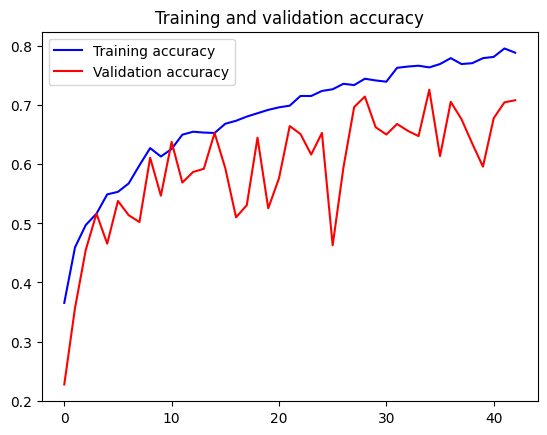

<Figure size 640x480 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

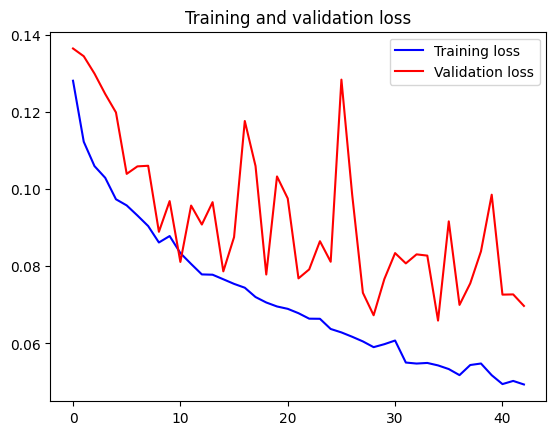

<Figure size 640x480 with 0 Axes>

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [40]:
def getMax(arr):
    max = 0
    for elem in arr:
        if elem > max:
            max = elem
    return max

In [47]:

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  np.set_printoptions(suppress = True)
  # print(classes[0])
  # print(np.argmax(classes[0]))

  print("It is", labels[np.argmax(classes[0])])

Saving metal.jpg to metal (3).jpg
Saving paper1.jpg to paper1 (1).jpg
Saving paper.jpg to paper (1).jpg
1/1 [==============================] - 0s 18ms/step
It is paper
1/1 [==============================] - 0s 18ms/step
It is paper
1/1 [==============================] - 0s 20ms/step
It is paper


In [57]:
labels.sort()
print(labels)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
